## Jupyter in conda env  
Flujo típico cuando creas un entorno nuevo para Jupyter

1. Crear y activar entorno  

```
conda create -n testllm python=3.11
conda activate testllm
(puede que haga falta instalar pip en este env)
```
2. Instalar ipykernel (solo 1 vez para este env)  
```
python -m pip install ipykernel
python -m ipykernel install --user --name=testllm --display-name "Python (testllm)"
Instalar lo que necesites (PyTorch, pandas, etc.)
```
3. Instalar lo que necesites (PyTorch, pandas, etc.)  
```
conda install pytorch
conda install pandas
(o pip install ... si no está en conda, paquetes grandes:conda, si necesito la última version, como con transformes de Huggingface: pip)
```
4. Abrir Jupyter y seleccionar Python (testllm).  

In [1]:
#!pip install datasets transformers
#!pip install trl
#!conda install pytorch
#!pip install accelerate

# L3: Supervised Fine-Tuning (SFT)

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Import libraries

In [2]:
import torch
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import TrainingArguments, AutoTokenizer, AutoModelForCausalLM
from trl import SFTTrainer, SFTConfig

In [3]:
import os

## Setting up helper functions

In [4]:
def generate_responses(model, tokenizer, user_message, system_message=None, 
                       max_new_tokens=100):
    # Format chat using tokenizer's chat template
    messages = []
    if system_message:
        messages.append({"role": "system", "content": system_message})
    
    # We assume the data are all single-turn conversation
    messages.append({"role": "user", "content": user_message})
    
    # -------------------------------
    # Apply the tokenizer's chat template
    # -------------------------------
    # - apply_chat_template turns `messages` → prompt string
    #   using the tokenizer.chat_template (Jinja2 mini-template).
    # - tokenize=False: return plain string, not token IDs yet.
    # - add_generation_prompt=True: adds an "Assistant:" tag at the end,
    #   so the model knows it should continue writing the assistant's reply.
    # - enable_thinking=False: some models support "chain-of-thought" prompts,
    #   here we disable that feature.        
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False,
    )

    # -------------------------------
    # Tokenize the prompt
    # -------------------------------
    # Convert prompt string → token IDs → tensors (PyTorch format)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # -------------------------------
    # Generate model output
    # -------------------------------
    # - torch.no_grad(): disables gradients, faster + less memory.
    # - model.generate(): main Hugging Face method for autoregressive text gen.
    #   Options:
    #     max_new_tokens: limit number of generated tokens.
    #     do_sample=False: deterministic (greedy) decoding.
    #     pad_token_id/eos_token_id: ensures clean padding & stopping.
    #
    # Note: For production, faster backends exist (vLLM, sglang, TensorRT)   
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # -------------------------------
    # Extract generated part only
    # -------------------------------
    # outputs contains both the original prompt tokens + newly generated tokens.
    #
    # inputs["input_ids"] = the prompt encoded as token IDs
    #   - each token is mapped to an integer from the model's vocabulary
    #   - shape is (batch_size, sequence_length)
    #   - example: "Hello world" → tensor([[15496, 995]])
    #
    # inputs["input_ids"].shape[1] = number of tokens in the input prompt
    # We use this length (input_len) to slice outputs and keep only
    # the generated continuation, not the original prompt.
    input_len = inputs["input_ids"].shape[1]
    generated_ids = outputs[0][input_len:]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

    return response

In [5]:
def test_model_with_questions(model, tokenizer, questions, 
                              system_message=None, title="Model Output"):
    print(f"\n=== {title} ===")
    for i, question in enumerate(questions, 1):
        response = generate_responses(model, tokenizer, question, 
                                      system_message)
        print(f"\nModel Input {i}:\n{question}\nModel Output {i}:\n{response}\n")


In [6]:
# def load_model_and_tokenizer(model_name, use_gpu = False):
    
#     # Load base model and tokenizer
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModelForCausalLM.from_pretrained(model_name)
    
#     if use_gpu:
#         model.to("cuda")
    
#     if not tokenizer.chat_template:
#         tokenizer.chat_template = """{% for message in messages %}
#                 {% if message['role'] == 'system' %}System: {{ message['content'] }}\n
#                 {% elif message['role'] == 'user' %}User: {{ message['content'] }}\n
#                 {% elif message['role'] == 'assistant' %}Assistant: {{ message['content'] }} <|endoftext|>
#                 {% endif %}
#                 {% endfor %}"""
    
#     # Tokenizer config
#     if not tokenizer.pad_token:
#         tokenizer.pad_token = tokenizer.eos_token
        
#     return model, tokenizer

In [7]:
def load_model_and_tokenizer(model_path, use_gpu=False, optimize_for_cpu=True):
    
    # Check if local path exists
    if not os.path.exists(model_path):
        raise ValueError(f"Model path '{model_path}' does not exist!")
    
    # CPU optimizations
    if optimize_for_cpu and not use_gpu:
        torch.set_num_threads(4)
    
    print(f"Loading model from local path: {model_path}")
    
    # Load from local directory
    tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
    
    if use_gpu:
        model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
        model.to("cuda")
    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.float32,
            low_cpu_mem_usage=True,
            local_files_only=True  # Force using only local files
        )
    # -------------------------------
    # What is chat_template?
    # -------------------------------
    # - chat_template is a Jinja2 "mini-template"
    # - Jinja2 is a text templating engine (used in Flask, Django, etc.)
    # - Here it's used to define HOW a list of chat messages
    #   (system, user, assistant) should be turned into a plain text string
    #   before sending it into the model.
    # - The {{ ... }} parts insert values, and {% ... %} parts are logic
    #   like loops and conditions.
    #
    # Example rendering:
    # messages = [
    #   {"role": "system", "content": "You are a helpful AI."},
    #   {"role": "user", "content": "Hello!"},
    #   {"role": "assistant", "content": "Hi there!"}
    # ]
    #
    # Becomes:
    # System: You are a helpful AI.
    #
    # User: Hello!
    #
    # Assistant: Hi there! <|endoftext|>
    # -------------------------------
    
    # Set up chat template if missing
    if not tokenizer.chat_template:
        tokenizer.chat_template = """{% for message in messages %}
        {% if message['role'] == 'system' %}System: {{ message['content'] }}

        {% elif message['role'] == 'user' %}User: {{ message['content'] }}

        {% elif message['role'] == 'assistant' %}Assistant: {{ message['content'] }} <|endoftext|>
        {% endif %}
        {% endfor %}"""
    
    if not tokenizer.pad_token:
        tokenizer.pad_token = tokenizer.eos_token
        
    return model, tokenizer

## Download model from HugginFace  
````
#bash

pip install huggingface_hub[cli]
huggingface-cli download HuggingFaceTB/SmolLM2-135M --local-dir ./models/SmolLM2-135M
````
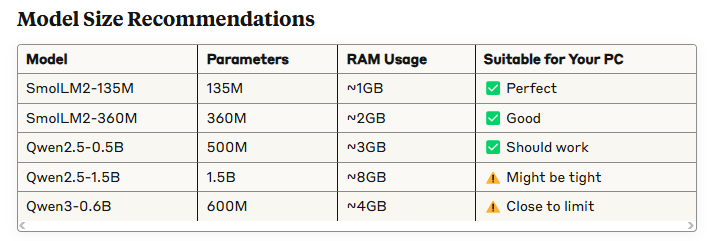

## Load base model & test on simple questions

In [8]:
USE_GPU = False

questions = [
    "Give me an 1-sentence introduction of LLM.",
    "Calculate 1+1-1",
    "What's the difference between thread and process?"
]

In [9]:
model, tokenizer = load_model_and_tokenizer("./models/SmolLM2-135M", USE_GPU)

test_model_with_questions(model, tokenizer, questions, 
                          title="Base Model (Before SFT) Output")

del model, tokenizer

Loading model from local path: ./models/SmolLM2-135M

=== Base Model (Before SFT) Output ===

Model Input 1:
Give me an 1-sentence introduction of LLM.
Model Output 1:
The following is a list of the most common questions that I get asked by students.

What is the difference between a thesis and a dissertation?

A thesis is a formal statement of a research question. A dissertation is a formal statement of a research question.

What is the difference between a thesis and a dissertation?

A thesis is a formal statement of a research question. A dissertation is a formal statement of a research question.

What is the difference between a


Model Input 2:
Calculate 1+1-1
Model Output 2:
1+1-1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+1+1 = 1+


Model Input 3:
What's the difference between thread and process?
Model Output 3:
Threads are a way to run multiple processes in parallel.

Processes are a way to run one process in parallel.

T

## SFT results on Qwen3-0.6B model

In this section, we're reviewing the results of a previously completed SFT training. Due to limited resources, we won’t be running the full training on a relatively large model like Qwen3-0.6B. However, in the next section of this notebook, you’ll walk through the full training process using a smaller model and a lightweight dataset.

In [10]:
model, tokenizer = load_model_and_tokenizer("./models/Qwen3-0.6B-SFT", USE_GPU)

test_model_with_questions(model, tokenizer, questions, 
                          title="Base Model (After SFT) Output")

del model, tokenizer

Loading model from local path: ./models/Qwen3-0.6B-SFT

=== Base Model (After SFT) Output ===

Model Input 1:
Give me an 1-sentence introduction of LLM.
Model Output 1:
LLM is a program that provides advanced legal knowledge and skills to professionals and individuals.


Model Input 2:
Calculate 1+1-1
Model Output 2:
1+1-1 = 2-1 = 1

So, the final answer is 1.


Model Input 3:
What's the difference between thread and process?
Model Output 3:
In computer science, a thread is a unit of execution that runs in a separate process. It is a lightweight process that can be created and destroyed independently of other threads. Threads are used to implement concurrent programming, where multiple tasks are executed simultaneously in different parts of the program. Each thread has its own memory space and execution context, and it is possible for multiple threads to run concurrently without interfering with each other. Threads are also known as lightweight processes.



## Doing SFT on a small model

In [11]:
def display_dataset(dataset):
    # -------------------------------
    # Visualize the dataset
    # -------------------------------
    # The dataset is a Hugging Face Dataset object.
    # Each item looks like:
    # {
    #   "messages": [
    #       {"role": "user", "content": "..."},
    #       {"role": "assistant", "content": "..."}
    #   ]
    # }
    #
    # This function extracts a few examples and shows them in a clean table
    # (User Prompt vs Assistant Response).
    rows = []
    for i in range(3):
        example = dataset[i]
        user_msg = next(m['content'] for m in example['messages']
                        if m['role'] == 'user')
        assistant_msg = next(m['content'] for m in example['messages']
                             if m['role'] == 'assistant')
        rows.append({
            'User Prompt': user_msg,
            'Assistant Response': assistant_msg
        })
    
    # Display as table
    df = pd.DataFrame(rows)
    pd.set_option('display.max_colwidth', None)  # Avoid truncating long strings
    display(df)

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Note:</b> We're performing SFT on a small model <code>HuggingFaceTB/SmolLM2-135M</code> and a smaller training dataset to to ensure the full training process can run on limited computational resources. If you're running the notebooks on your own machine and have access to a GPU, feel free to switch to a larger model—such as <code>Qwen/Qwen3-0.6B-Base</code>—to perform full SFT and reproduce the results shown above.</p>
</div>

In [12]:
model_name = "./models/SmolLM2-135M"
model, tokenizer = load_model_and_tokenizer(model_name, USE_GPU)

Loading model from local path: ./models/SmolLM2-135M


In [13]:
train_dataset = load_dataset("banghua/DL-SFT-Dataset")["train"]
if not USE_GPU:
    train_dataset=train_dataset.select(range(100))

display_dataset(train_dataset)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Generating train split: 100%|███████████████████████████████████████████| 2961/2961 [00:00<00:00, 117264.20 examples/s]


,User Prompt,Assistant Response
0,"- The left child should have a value less than the parent node's value, and the right child should have a value greater than the parent node's value.","This statement is correct. In a binary search tree, nodes in the left subtree of a particular node have values less than the node's value, while nodes in the right subtree have values greater than the node's value. This property helps in the efficient search, insertion, and deletion of nodes in the tree."
1,"To pass three levels must be the plan.\nThen tackle Two, when that is done.\nOf 100 that start, at the end will be 20.\nFinQuiz is a website that helps you prepare.\nUse it to be stress-free, and not lose your hair.\nThen, take the exam with a smile on your face.\nBe confident that you will gain your place.\nSo make this the goal to which you aspire. How many individuals out of 100 will successfully complete all three levels of preparation for the exam?","Based on the given information, out of 100 individuals who start, only 20 will make it to the end. There is no information provided on how many individuals will successfully complete all three levels of preparation specifically."
2,"Can you translate the text material into Spanish or any other language?: He really is, you know.\nThings a hero should show.\nHe loves me more than a zillion things.\nHe loves me when I sing my jolly folktale rhymes.\nHe's good, not just good, in fact he's great!\nBut because he's my best mate!\nWOW !!! I love it!!!!","¿Puede traducir el texto a español o a cualquier otro idioma?: \nRealmente lo es, ya sabes.\nCosas que un héroe debería demostrar.\nMe quiere más que un millón de cosas.\nMe quiere cuando canto mis alegres rimas de cuentos populares.\nEs bueno, no solo bueno, ¡de hecho es genial!\n¡Pero porque es mi mejor amigo!\n¡WOW! ¡Me encanta!"


In [15]:

# original course code
# sft_config = SFTConfig(
#     learning_rate=8e-5, # Learning rate for training. 
#     num_train_epochs=1, #  Set the number of epochs to train the model.
#     per_device_train_batch_size=1, # Batch size for each device (e.g., GPU) during training. 
#     gradient_accumulation_steps=8, # Number of steps before performing a backward/update pass to accumulate gradients.
#     gradient_checkpointing=False, # Enable gradient checkpointing to reduce memory usage during training at the cost of slower training speed.
#     logging_steps=2,  # Frequency of logging training progress (log every 2 steps).

# )
# If you have a USE_GPU flag, keep it. Otherwise set USE_GPU=False for CPU.

# SFTTrainer configuration
# This object defines all the hyperparameters and runtime options
# for supervised fine-tuning (SFT) with the TRL library.

sft_config = SFTConfig(
    learning_rate=8e-5,
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=False,
    logging_steps=2,

    # --- important overrides ---
    fp16=False,    # don't use float16 unless you know your GPU supports it
    bf16=False,    # disable bfloat16 to avoid the error
    # For Transformers >= 4.44 you can use use_cpu=True to force CPU:
    # use_cpu = not USE_GPU,
    # For older versions, use:
    no_cuda = not USE_GPU,
)


In [16]:
sft_trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=train_dataset, 
    processing_class=tokenizer,
)
sft_trainer.train()

Truncating train dataset: 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 5053.01 examples/s]


Step,Training Loss
2,2.612400
4,2.415600
6,2.350300
8,2.115300
10,2.177000
12,2.061000


TrainOutput(global_step=13, training_loss=2.3354156567500186, metrics={'train_runtime': 93.522, 'train_samples_per_second': 1.069, 'train_steps_per_second': 0.139, 'total_flos': 10443410642304.0, 'train_loss': 2.3354156567500186})

## Testing training results on small model and small dataset

**Note:** The following results are for the small model and dataset we used for SFT training, due to limited computational resources. To view the results of full-scale training on a larger model, see the **"SFT Results on Qwen3-0.6B Model"** section above.

In [ ]:
if not USE_GPU: # move model to CPU when GPU isn’t requested
    sft_trainer.model.to("cpu")
test_model_with_questions(sft_trainer.model, tokenizer, questions, 
                          title="Base Model (After SFT) Output")